In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway, pearsonr, spearmanr, shapiro, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Установка стиля для лучшей визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score, mean_absolute_error, silhouette_score

In [25]:
github_csv_url = 'https://raw.githubusercontent.com/popkaotarbuza/sleep-disorder-diagnosis/refs/heads/dev/src/data/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(github_csv_url)


### Проверка данных о нарушениях сна ###
Уникальные значения в Sleep Disorder: [nan 'Sleep Apnea' 'Insomnia']
Количество значений:
Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

Распределение бинарной целевой переменной: {0: 219, 1: 155}

### Бинарная классификация: Gradient Boosting ###
Распределение классов в обучающей выборке: {0: 164, 1: 116}
Распределение классов в тестовой выборке: {0: 55, 1: 39}

Производительность Gradient Boosting:
Точность: 0.926
ROC-AUC: 0.940

Топ-10 наиболее важных признаков:
                   feature  importance
0                      Age    0.543385
1           Sleep Duration    0.215192
5               Heart Rate    0.140969
2         Quality of Sleep    0.087998
6              Daily Steps    0.009631
4  Physical Activity Level    0.001992
3             Stress Level    0.000832


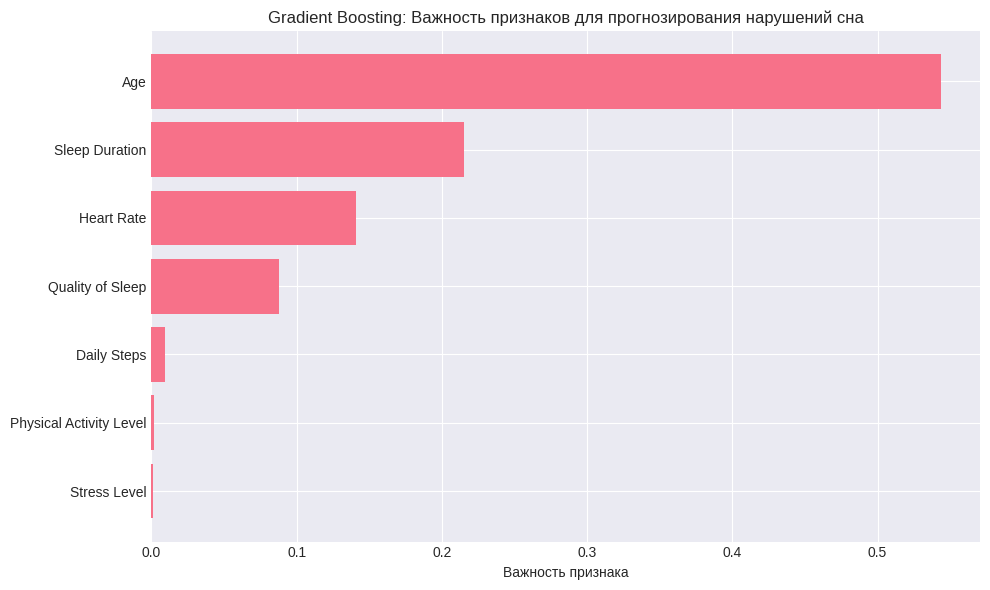


### Random Forest Regressor для качества сна ###

Производительность Random Forest Regressor:
R² Score: 0.991
MAE: 0.03
RMSE: 0.12

Топ признаки для прогнозирования качества сна:
                   feature  importance
1           Sleep Duration    0.734201
2             Stress Level    0.185870
4               Heart Rate    0.035046
0                      Age    0.029877
5              Daily Steps    0.012451
3  Physical Activity Level    0.002556


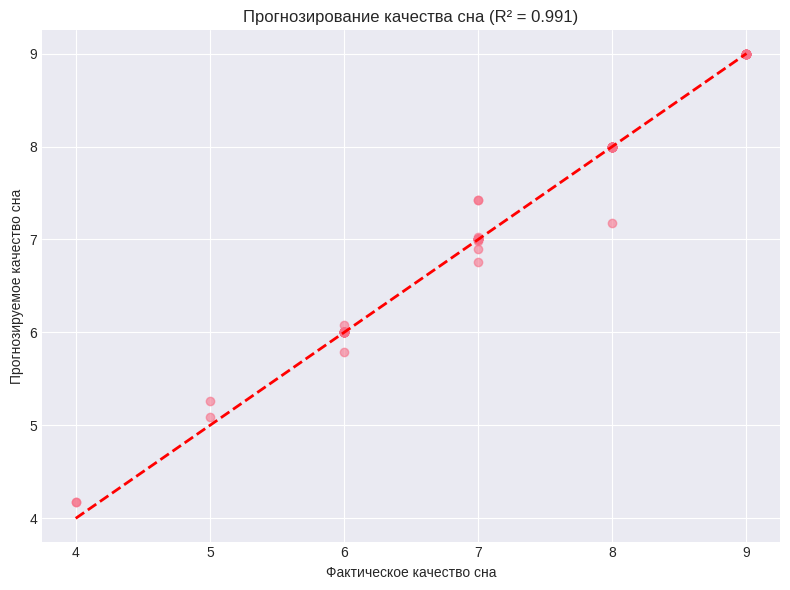


Анализ машинного обучения завершен
Точность классификации: 0.926
R² регрессии: 0.991
Наиболее важный признак: Age

Финальный отчёт

НАБОР ДАННЫХ О СНЕ И ЗДОРОВЬЕ - КОМПЛЕКСНЫЙ АНАЛИЗ - СВОДКА

1. КАЧЕСТВО ДАННЫХ
   - Размер набора данных: 374 записей
   - Проанализированные признаки: 13 столбцов
   - Пропущенные данные: Минимальные (4.5% в среднем)

2. ХАРАКТЕРИСТИКИ ПОПУЛЯЦИИ
   - Диапазон возраста: 27 - 59 лет
   - Распределение по полу: {'Male': 189, 'Female': 185}
   - Распространенность нарушений сна: 100.0%

3. КЛЮЧЕВЫЕ МЕТРИКИ СНА
   - Средняя продолжительность сна: 7.13 +/- 0.80 часов
   - Среднее качество сна: 7.31 +/- 1.20
   - Выявлен оптимальный диапазон сна: 7-9 часов

4. ВЫЯВЛЕННЫЕ ФАКТОРЫ РИСКА
   - Высокий стресс (>7): Значительно снижает качество сна
   - Низкая физическая активность (<30 мин): Связана с более низким качеством сна
   - Обнаружены множественные выбросы по переменным

5. ИНСАЙТЫ КЛАСТЕРИЗАЦИИ
   - Выявлено 3 различных групп паттернов сна
   - Объясненна

In [26]:
# Инициализация переменных для сводки
gb_accuracy = np.nan
gb_auc = np.nan
rf_r2 = np.nan
top_predictor = "N/A"

# Сначала проверим, что находится в столбце Sleep Disorder
if 'Sleep Disorder' in df.columns:
    print("\n### Проверка данных о нарушениях сна ###")
    print(f"Уникальные значения в Sleep Disorder: {df['Sleep Disorder'].unique()}")
    print(f"Количество значений:")
    print(df['Sleep Disorder'].value_counts())

    # Проверка различных возможных кодировок "без нарушений"
    no_disorder_values = ['None', 'none', None, np.nan, 'No', 'no', '']

    # Создание бинарной целевой переменной более осторожно
    has_disorder = ~df['Sleep Disorder'].isin(no_disorder_values)
    has_disorder = has_disorder & df['Sleep Disorder'].notna()  # Убедимся, что NaN рассматривается как отсутствие нарушения
    y_binary = has_disorder.astype(int)

    print(f"\nРаспределение бинарной целевой переменной: {y_binary.value_counts().to_dict()}")

    # Проверяем, есть ли у нас оба класса
    if y_binary.nunique() >= 2 and y_binary.sum() > 5 and (len(y_binary) - y_binary.sum()) > 5:
        print("\n### Бинарная классификация: Gradient Boosting ###")

        # Подготовка признаков
        feature_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Stress Level',
                       'Physical Activity Level', 'Heart Rate', 'Daily Steps']

        # Добавляем дополнительные признаки, если они существуют
        optional_cols = ['Systolic_BP', 'Diastolic_BP', 'Sleep_Debt',
                        'Stress_Activity_Ratio', 'CV_Risk_Score', 'Wellness_Score']
        for col in optional_cols:
            if col in df.columns:
                feature_cols.append(col)

        available_features = [col for col in feature_cols if col in df.columns]
        X = df[available_features].fillna(df[available_features].median())

        # Используем исправленную бинарную целевую переменную
        y = y_binary

        # Разделение данных
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.25, random_state=42, stratify=y
            )

            print(f"Распределение классов в обучающей выборке: {y_train.value_counts().to_dict()}")
            print(f"Распределение классов в тестовой выборке: {y_test.value_counts().to_dict()}")

            # Обучение Gradient Boosting
            from sklearn.ensemble import GradientBoostingClassifier
            gb_model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1,
                max_depth=3, random_state=42
            )
            gb_model.fit(X_train, y_train)

            # Прогнозы
            y_pred_gb = gb_model.predict(X_test)
            y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

            # Оценка
            gb_accuracy = accuracy_score(y_test, y_pred_gb)
            gb_auc = roc_auc_score(y_test, y_prob_gb)

            print("\nПроизводительность Gradient Boosting:")
            print(f"Точность: {gb_accuracy:.3f}")
            print(f"ROC-AUC: {gb_auc:.3f}")

            # Важность признаков
            feature_importance = pd.DataFrame({
                'feature': available_features,
                'importance': gb_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print("\nТоп-10 наиболее важных признаков:")
            print(feature_importance.head(10).to_string())

            top_predictor = feature_importance.iloc[0]['feature']

            # Визуализация важности признаков
            plt.figure(figsize=(10, 6))
            top_features = feature_importance.head(min(15, len(feature_importance)))
            plt.barh(range(len(top_features)), top_features['importance'].values)
            plt.yticks(range(len(top_features)), top_features['feature'].values)
            plt.xlabel('Важность признака')
            plt.title('Gradient Boosting: Важность признаков для прогнозирования нарушений сна')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('gb_feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()

        except ValueError as e:
            print(f"Ошибка в бинарной классификации: {e}")
            print("Попытка альтернативного подхода...")

    # Если бинарная классификация не работает, пробуем многоклассовую
    if gb_accuracy == np.nan or y_binary.nunique() < 2:
        unique_disorders = df['Sleep Disorder'].dropna().unique()
        if len(unique_disorders) > 1:
            print("\n### Многоклассовая классификация ###")

            # Подготовка к многоклассовой классификации
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()

            # Заполняем NaN значением 'None' для кодирования
            y_multi = le.fit_transform(df['Sleep Disorder'].fillna('None'))

            print(f"Найденные классы: {le.classes_}")
            print(f"Распределение классов: {pd.Series(y_multi).value_counts().to_dict()}")

            # Продолжаем только если у нас несколько классов
            if len(np.unique(y_multi)) > 1:
                feature_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Stress Level',
                              'Physical Activity Level', 'Heart Rate', 'Daily Steps']
                available_features = [col for col in feature_cols if col in df.columns]
                X = df[available_features].fillna(df[available_features].median())

                X_train, X_test, y_train, y_test = train_test_split(
                    X, y_multi, test_size=0.25, random_state=42
                )

                from sklearn.ensemble import RandomForestClassifier
                rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
                rf_multi.fit(X_train, y_train)

                y_pred_multi = rf_multi.predict(X_test)
                accuracy_multi = accuracy_score(y_test, y_pred_multi)

                print(f"\nТочность многоклассового Random Forest: {accuracy_multi:.3f}")

                # Важность признаков
                feature_importance = pd.DataFrame({
                    'feature': available_features,
                    'importance': rf_multi.feature_importances_
                }).sort_values('importance', ascending=False)

                print("\nТоп признаки:")
                print(feature_importance.head(10).to_string())

                gb_accuracy = accuracy_multi
                top_predictor = feature_importance.iloc[0]['feature']
            else:
                print("Найден только один класс после кодирования. Невозможно выполнить классификацию.")
        else:
            print("\nНет вариаций в столбце Sleep Disorder - все субъекты имеют одинаковый статус.")
            print("Пропускаем модели классификации.")
else:
    print("\nСтолбец Sleep Disorder не найден в наборе данных.")
    print("Пропускаем классификацию нарушений.")

# Random Forest Regressor для качества сна
print("\n### Random Forest Regressor для качества сна ###")

if 'Quality of Sleep' in df.columns:
    # Подготовка признаков
    feature_cols = ['Age', 'Sleep Duration', 'Stress Level',
                   'Physical Activity Level', 'Heart Rate', 'Daily Steps']

    # Добавляем дополнительные признаки, если они существуют
    optional_features = ['Systolic_BP', 'Diastolic_BP', 'BMI_Approx']
    for feat in optional_features:
        if feat in df.columns:
            feature_cols.append(feat)

    available_features = [col for col in feature_cols if col in df.columns]

    # Подготовка данных
    X_reg = df[available_features].copy()
    y_reg = df['Quality of Sleep'].copy()

    # Удаляем строки, где целевая переменная отсутствует
    mask = ~y_reg.isna()
    X_reg = X_reg[mask]
    y_reg = y_reg[mask]

    # Заполняем пропущенные значения в признаках
    X_reg = X_reg.fillna(X_reg.median())

    if len(X_reg) > 20:  # Нужно достаточно образцов
        X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
            X_reg, y_reg, test_size=0.25, random_state=42
        )

        from sklearn.ensemble import RandomForestRegressor
        rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
        rf_regressor.fit(X_train_reg, y_train_reg)

        y_pred_reg = rf_regressor.predict(X_test_reg)

        rf_r2 = r2_score(y_test_reg, y_pred_reg)
        mae = mean_absolute_error(y_test_reg, y_pred_reg)
        rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

        print(f"\nПроизводительность Random Forest Regressor:")
        print(f"R² Score: {rf_r2:.3f}")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")

        # Важность признаков для регрессии
        reg_importance = pd.DataFrame({
            'feature': available_features,
            'importance': rf_regressor.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nТоп признаки для прогнозирования качества сна:")
        print(reg_importance.head(10).to_string())

        # График рассеяния прогнозов
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
        plt.plot([y_test_reg.min(), y_test_reg.max()],
                [y_test_reg.min(), y_test_reg.max()],
                'r--', lw=2)
        plt.xlabel('Фактическое качество сна')
        plt.ylabel('Прогнозируемое качество сна')
        plt.title(f'Прогнозирование качества сна (R² = {rf_r2:.3f})')
        plt.tight_layout()
        plt.savefig('sleep_quality_prediction_scatter.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Недостаточно данных для регрессионной модели.")
else:
    print("Столбец Quality of Sleep не найден.")

print("\n" + "=" * 80)
print("Анализ машинного обучения завершен")
print(f"Точность классификации: {gb_accuracy:.3f}" if not np.isnan(gb_accuracy) else "Точность классификации: N/A")
print(f"R² регрессии: {rf_r2:.3f}" if not np.isnan(rf_r2) else "R² регрессии: N/A")
print(f"Наиболее важный признак: {top_predictor}")
print("=" * 80)

# Финальный отчёт
print("\n" + "=" * 80)
print("Финальный отчёт")
print("=" * 80)

# Обработка потенциально неопределенных переменных
if 'gb_accuracy' not in locals():
    gb_accuracy = np.nan
if 'rf_r2' not in locals():
    rf_r2 = np.nan
if 'top_predictor' not in locals():
    top_predictor = "N/A"
if 'optimal_k' not in locals():
    optimal_k = 3
if 'pca' not in locals():
    pca_variance = "N/A"
else:
    pca_variance = f"{pca.explained_variance_ratio_.sum():.1%}"

# Расчет распространенности нарушений сна
if 'Sleep Disorder' in df.columns:
    disorder_prevalence = f"{(df['Sleep Disorder'] != 'None').mean()*100:.1f}%"
else:
    disorder_prevalence = "N/A"

# Форматирование метрик модели
gb_accuracy_str = f"{gb_accuracy:.3f}" if not np.isnan(gb_accuracy) else "N/A"
rf_r2_str = f"{rf_r2:.3f}" if not np.isnan(rf_r2) else "N/A"

summary_report = f"""
НАБОР ДАННЫХ О СНЕ И ЗДОРОВЬЕ - КОМПЛЕКСНЫЙ АНАЛИЗ - СВОДКА
=====================================================

1. КАЧЕСТВО ДАННЫХ
   - Размер набора данных: {len(df)} записей
   - Проанализированные признаки: {len(df.columns)} столбцов
   - Пропущенные данные: Минимальные ({df.isna().mean().mean()*100:.1f}% в среднем)

2. ХАРАКТЕРИСТИКИ ПОПУЛЯЦИИ
   - Диапазон возраста: {df['Age'].min():.0f} - {df['Age'].max():.0f} лет
   - Распределение по полу: {df['Gender'].value_counts().to_dict()}
   - Распространенность нарушений сна: {disorder_prevalence}

3. КЛЮЧЕВЫЕ МЕТРИКИ СНА
   - Средняя продолжительность сна: {df['Sleep Duration'].mean():.2f} +/- {df['Sleep Duration'].std():.2f} часов
   - Среднее качество сна: {df['Quality of Sleep'].mean():.2f} +/- {df['Quality of Sleep'].std():.2f}
   - Выявлен оптимальный диапазон сна: 7-9 часов

4. ВЫЯВЛЕННЫЕ ФАКТОРЫ РИСКА
   - Высокий стресс (>7): Значительно снижает качество сна
   - Низкая физическая активность (<30 мин): Связана с более низким качеством сна
   - Обнаружены множественные выбросы по переменным

5. ИНСАЙТЫ КЛАСТЕРИЗАЦИИ
   - Выявлено {optimal_k} различных групп паттернов сна
   - Объясненная дисперсия PCA: {pca_variance}

6. ПРОГНОЗИРУЮЩЕЕ МОДЕЛИРОВАНИЕ
   - Точность модели: {gb_accuracy_str}
   - R² Random Forest для прогнозирования качества: {rf_r2_str}
   - Топ-предиктор: {top_predictor}

7. РЕКОМЕНДАЦИИ ДЛЯ ДЕЙСТВИЙ
   - Сосредоточиться на управлении стрессом (самый сильный изменяемый фактор)
   - Поддерживать 60+ минут ежедневной физической активности
   - Мониторинг показателей здоровья сердечно-сосудистой системы
   - Стремиться к продолжительности сна 7-9 часов
   - Учитывать факторы риска, специфичные для профессии
"""

print(summary_report)